In [21]:
pip install geopandas pyproj pandas


Note: you may need to restart the kernel to use updated packages.


In [101]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point

#  read in data
file_path = "data/cleaned_listings.csv"
df = pd.read_csv(file_path)

#  creat the points
geometry = [Point(xy) for xy in zip(df["longitude"], df["latitude"])]

#  Creat a GeoDataFrame，define the original CRS as WGS84
gdf = gpd.GeoDataFrame(df, geometry=geometry, crs="EPSG:4326")

# projection to the British CRS
gdf_projected = gdf.to_crs("EPSG:27700")



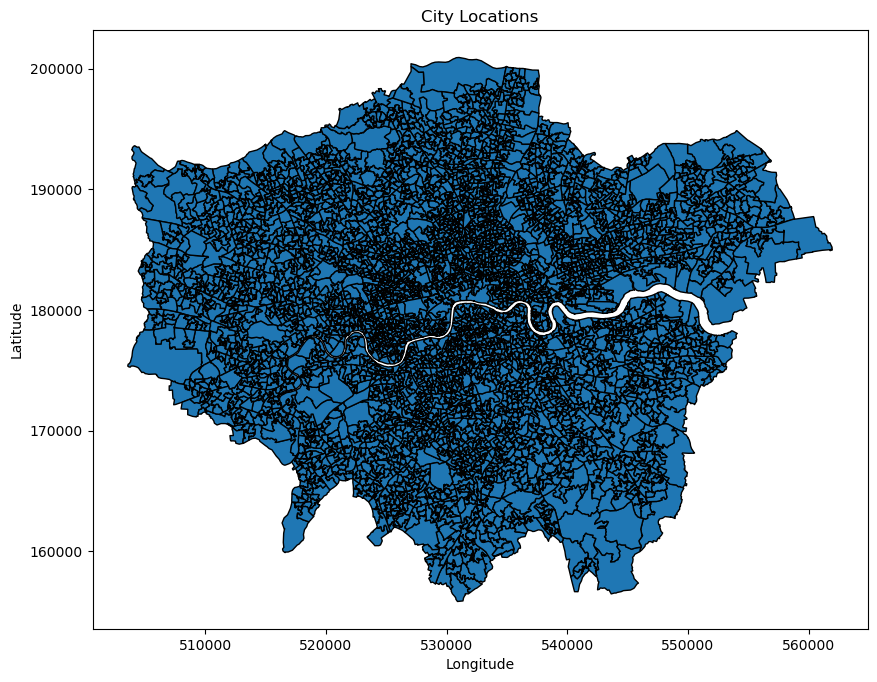

In [102]:
# read LOSA
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point
import matplotlib.pyplot as plt
file_path = "data/LSOA_2011_London_gen_MHW.shp"
lsoa = gpd.read_file(file_path)

# Visualization
lsoa.plot(figsize=(10, 10), edgecolor="black")

# Set the title and display
plt.title("City Locations")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

                        id  longitude   latitude   LSOA11CD
0                   116268  -0.118880  51.611370  E01001393
1                   117203  -0.233002  51.501550  E01001862
2                   127652  -0.144319  51.559528  E01000910
3                   131444  -0.111514  51.491476  E01003111
4                   137581  -0.078620  51.510990  E01032739
...                    ...        ...        ...        ...
63200  1239087592369786950  -0.143016  51.547717  E01000927
63201  1239112017665871678  -0.091734  51.505380  E01003929
63202  1239112357239275295  -0.091734  51.505380  E01003929
63203  1239116439240556456  -0.091734  51.505380  E01003929
63204  1239118358582762076  -0.393124  51.539411  E01001327

[63205 rows x 4 columns]


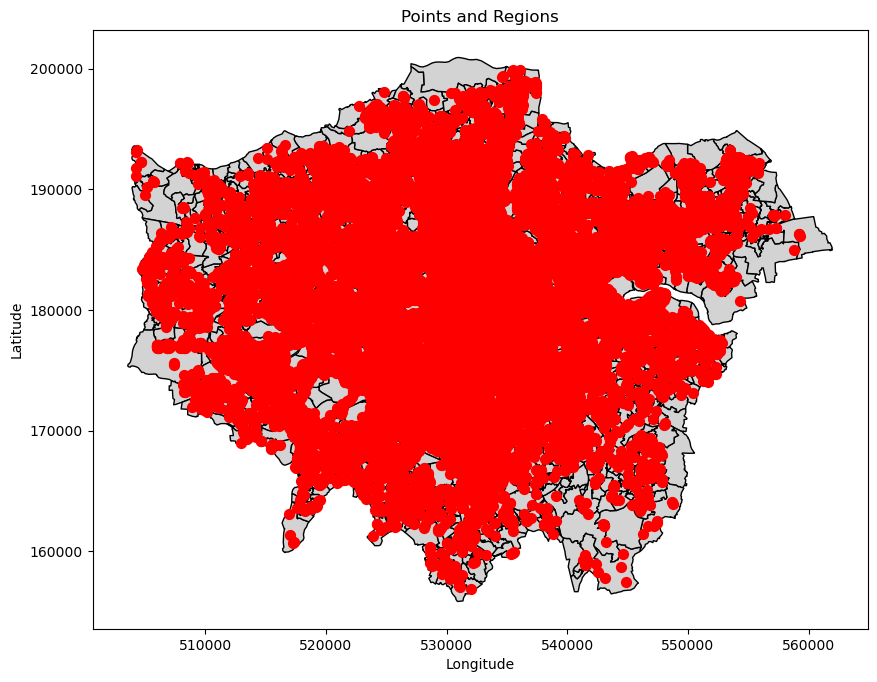

In [103]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point
import matplotlib.pyplot as plt
points_gdf = gdf.to_crs(lsoa.crs)
# spatial join
points_with_regions = gpd.sjoin(points_gdf, lsoa, how="left", predicate="within")

# add columns
points_with_regions = points_with_regions.rename(columns={"LSOA11CD": "LSOA11CD"})

# show the result
print(points_with_regions[["id", "longitude", "latitude", "LSOA11CD"]])

# visualization
fig, ax = plt.subplots(figsize=(10, 10))

# build the boundary
lsoa.plot(ax=ax, color="lightgrey", edgecolor="black")

# plot the points
points_with_regions.plot(ax=ax, color="red", markersize=50)
plt.title("Points and Regions")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

In [104]:
import geopandas as gpd


# calculate the ares
lsoa["Area_m2"] = lsoa.geometry.area
lsoa["Area_km2"] = lsoa["Area_m2"] / 1_000_000

# show the result
print(lsoa[["LSOA11CD","Area_km2"]].head())

    LSOA11CD  Area_km2
0  E01000001  0.133321
1  E01000002  0.226191
2  E01000003  0.057303
3  E01000005  0.190739
4  E01000006  0.144196


In [105]:
# Ensure consistent coordinate systems
if gdf.crs != "EPSG:27700":
    gdf = gdf.to_crs("EPSG:27700")

if lsoa.crs != "EPSG:27700":
    lsoa = lsoa.to_crs("EPSG:27700")

# spatial join
points_in_lsoa = gpd.sjoin(gdf, lsoa, how="left", predicate="within")

# 4. Count the points by area (LSOA11CD)
point_counts = points_in_lsoa.groupby("LSOA11CD").size().reset_index(name="Point_Count")
lsoa = lsoa.merge(point_counts, on="LSOA11CD", how="left")


# Fill NaN values with 0
lsoa["Point_Count"] = lsoa["Point_Count"].fillna(0)
lsoa["Density"] = lsoa["Point_Count"] / lsoa["Area_km2"]
# show the result
print(lsoa[["LSOA11CD", "Point_Count", "Area_m2", "Density"]].head())

    LSOA11CD  Point_Count        Area_m2     Density
0  E01000001         14.0  133320.768859  105.009895
1  E01000002          8.0  226191.273063   35.368296
2  E01000003          9.0   57302.966528  157.059932
3  E01000005         73.0  190738.760508  382.722420
4  E01000006          2.0  144195.846859   13.870025


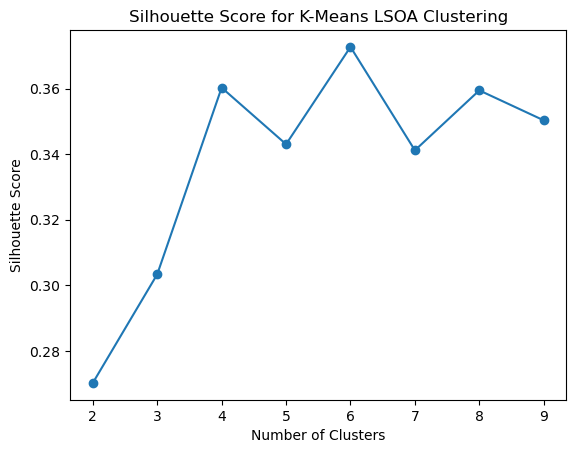

In [106]:
import geopandas as gpd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap

# Extract the geometric center and density values of the area.
lsoa["centroid"] = lsoa.geometry.centroid  
lsoa["x"] = lsoa["centroid"].x  
lsoa["y"] = lsoa["centroid"].y 
cluster_data = lsoa[["x", "y", "Density"]].values

# Data normalization
scaler = StandardScaler()
cluster_data_scaled = scaler.fit_transform(cluster_data)

# Get the suitable number of clusterings by silhouette_score
from sklearn.metrics import silhouette_score

silhouette_scores = []
for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(cluster_data_scaled)
    score = silhouette_score(cluster_data_scaled, labels)
    silhouette_scores.append(score)

plt.plot(range(2, 10), silhouette_scores, marker='o')
plt.title("Silhouette Score for K-Means LSOA Clustering")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.show()


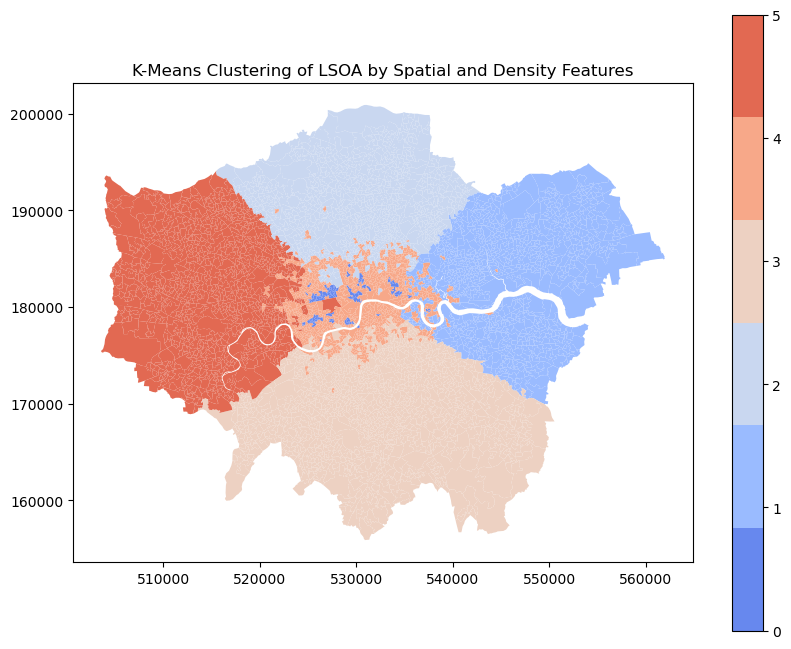

In [107]:
# Make clusterings of 6
n_clusters = 6 
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
lsoa["Cluster1"] = kmeans.fit_predict(cluster_data_scaled)  

# Visualization using seaborn color palette
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

# Choose a seaborn color palette and convert it to a ListedColormap
palette = sns.color_palette("coolwarm", n_colors=n_clusters)  # generate viridis color palette
cmap = ListedColormap(palette.as_hex())  # Convert palette to ListedColormap

# Plot using the chosen color palette with reduced transparency (alpha=1)
lsoa.plot(column="Cluster1", cmap=cmap, legend=True, ax=ax, alpha=1,linewidth=0.1)

plt.title("K-Means Clustering of LSOA by Spatial and Density Features")
plt.savefig("kmeans_clustering_lsoadensity_viridis.png", dpi=300, bbox_inches="tight")
plt.show()


Moran's I: 0.7436318863451462
p-value: 0.001


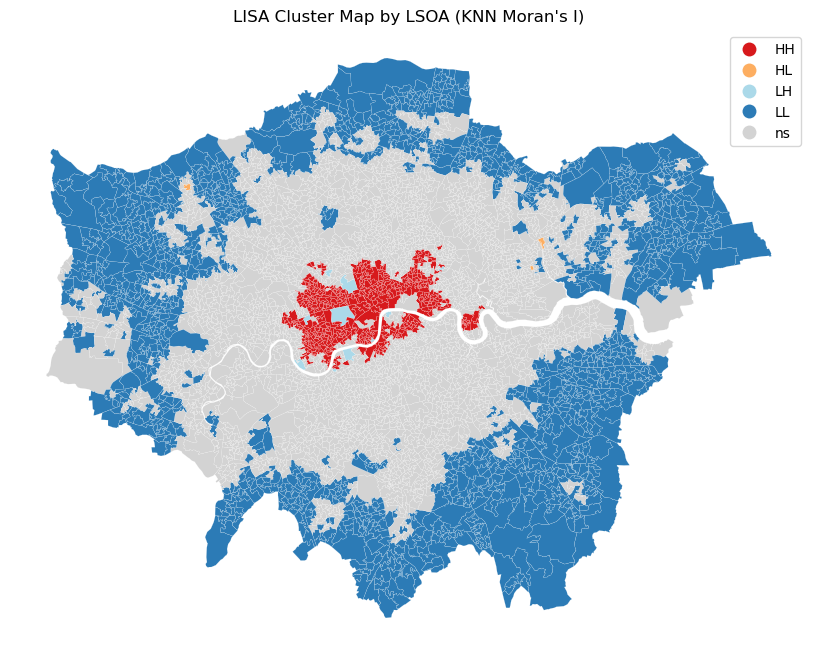

       LSOA11CD                   LSOA11NM   MSOA11CD  \
0     E01000001        City of London 001A  E02000001   
1     E01000002        City of London 001B  E02000001   
2     E01000003        City of London 001C  E02000001   
3     E01000005        City of London 001E  E02000001   
4     E01000006  Barking and Dagenham 016A  E02000017   
...         ...                        ...        ...   
4830  E01033742             Greenwich 007F  E02000319   
4831  E01033743             Greenwich 002H  E02000314   
4832  E01033744             Greenwich 007G  E02000319   
4833  E01033745             Greenwich 002I  E02000314   
4834  E01033746             Greenwich 038E  E02006931   

                      MSOA11NM    LAD11CD               LAD11NM    RGN11CD  \
0           City of London 001  E09000001        City of London  E12000007   
1           City of London 001  E09000001        City of London  E12000007   
2           City of London 001  E09000001        City of London  E12000007   
3  

In [108]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
from libpysal.weights import KNN  # Import KNN
from esda.moran import Moran, Moran_Local
from splot.esda import moran_scatterplot, lisa_cluster

# Create KNN contiguity weight matrix with k=5 (5 nearest neighbors).
k = 5  # Number of nearest neighbors
w = KNN.from_dataframe(lsoa, k=k)  # Create KNN weight matrix
# Weight matrix normalization.
w.transform = "r"

# Calculate global Moran's I.
moran = Moran(lsoa["Density"], w)
print(f"Moran's I: {moran.I}")
print(f"p-value: {moran.p_sim}")

# Calculate local Moran's I
lisa = Moran_Local(lsoa["Density"], w)

# Add cluster types and significance to the lsoa dataframe
lsoa["lisa_cluster"] = lisa.q  
lsoa["lisa_sig"] = lisa.p_sim  

# Cluster type description:
# 1 = High-High: High-value areas surrounded by high-value neighbors (High-value clusters)
# 2 = Low-Low: Low-value areas surrounded by low-value neighbors (Low-value clusters)
# 3 = High-Low: High-value areas surrounded by low-value neighbors (High-value outliers)
# 4 = Low-High: Low-value areas surrounded by high-value neighbors (Low-value outliers)

# Plot the LISA results
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
lisa_cluster(lisa, lsoa, p=0.05, ax=ax)
plt.title("LISA Cluster Map by LSOA (KNN Moran's I)")
plt.savefig("12_Moran'I_lsoadensity_knn.png", dpi=300, bbox_inches="tight")
plt.show()

# Print the updated lsoa data
print(lsoa)


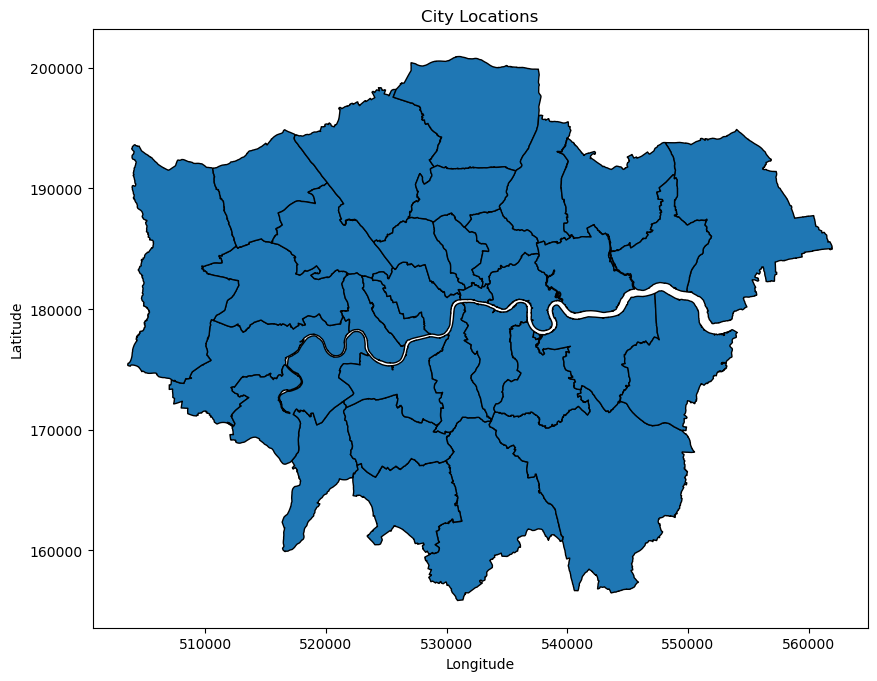

In [109]:
# read in borough area
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point
import matplotlib.pyplot as plt
file_path = "data/ESRI/London_Borough_Excluding_MHW.shp"
bor = gpd.read_file(file_path)

#  visualization
bor.plot(figsize=(10, 10), edgecolor="black")

#  set the title 
plt.title("City Locations")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

                        id           neighbourhood   latitude  longitude  \
0                   116268                 Enfield  51.611370  -0.118880   
1                   117203  Hammersmith and Fulham  51.501550  -0.233002   
2                   127652                  Camden  51.559528  -0.144319   
3                   131444                 Lambeth  51.491476  -0.111514   
4                   137581          City of London  51.510990  -0.078620   
...                    ...                     ...        ...        ...   
63200  1239087592369786950                  Camden  51.547717  -0.143016   
63201  1239112017665871678               Southwark  51.505380  -0.091734   
63202  1239112357239275295               Southwark  51.505380  -0.091734   
63203  1239116439240556456               Southwark  51.505380  -0.091734   
63204  1239118358582762076                  Ealing  51.539411  -0.393124   

             room_type  price                       geometry  index_right  \
0         

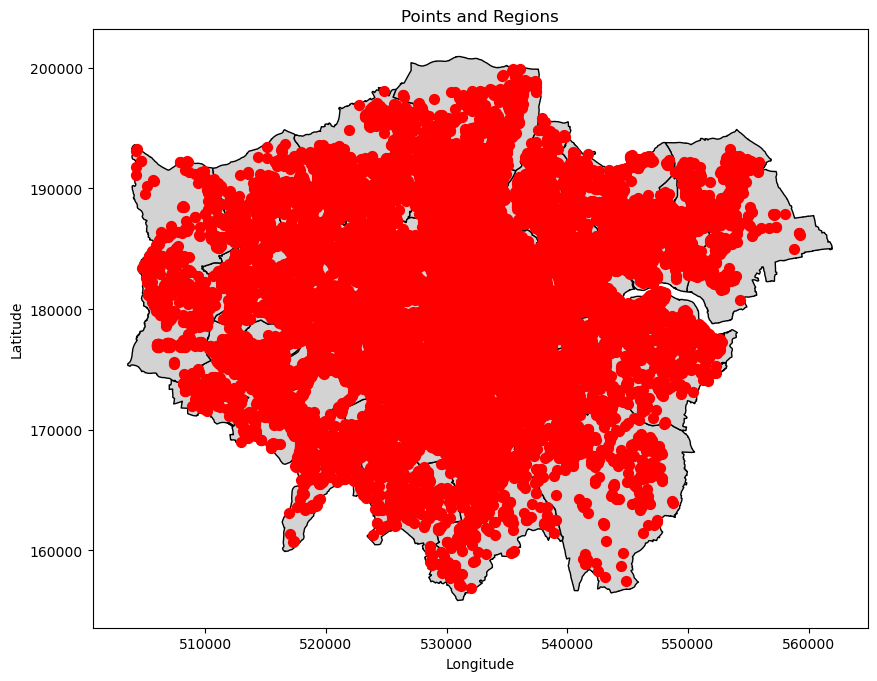

In [110]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point
import matplotlib.pyplot as plt
points_gdf = gdf.to_crs(bor.crs)
# Spatial Join: Linking point data with area data.
points_with_regions = gpd.sjoin(points_gdf, bor, how="left", predicate="within")

# Add the column as names of boroughs
points_with_regions = points_with_regions.rename(columns={"GSS_CODE": "GSS_CODE"})

# show the result
print(points_with_regions)
print(points_with_regions[["id", "longitude", "latitude", "GSS_CODE"]])

# show points in borough
fig, ax = plt.subplots(figsize=(10, 10))

# set the boundary
bor.plot(ax=ax, color="lightgrey", edgecolor="black")

# plot points
points_with_regions.plot(ax=ax, color="red", markersize=50)

# Add legend and title
plt.title("Points and Regions")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

In [111]:
import geopandas as gpd
#  Calculate area
bor["Area_m2"] = bor.geometry.area
bor["Area_km2"] = bor["Area_m2"] / 1_000_000

#  show the density
print(bor[["GSS_CODE","Area_km2"]].head())



    GSS_CODE    Area_km2
0  E09000021   37.261178
1  E09000008   86.494436
2  E09000006  150.134858
3  E09000018   55.926233
4  E09000009   55.544350


In [112]:
# make sure they are in the same coordinate system.
if gdf.crs != "EPSG:27700":
    gdf = gdf.to_crs("EPSG:27700")

if bor.crs != "EPSG:27700":
    bor = bor.to_crs("EPSG:27700")

# 3. spatial Join  
point_in_bor = gpd.sjoin(gdf, bor, how="left", predicate="within")

# 4. Count points by borough
Point_Counts = point_in_bor.groupby("GSS_CODE").size().reset_index(name="Point_Count")

# 5. Merge the point count results into the boroughs.
bor = bor.merge(Point_Counts, on="GSS_CODE", how="left")


# Fill NaN point count with 0.
bor["Point_Count"] = bor["Point_Count"].fillna(0)
bor["Density"] = bor["Point_Count"] / bor["Area_km2"]
# sow the result
print(bor[["GSS_CODE", "Point_Count", "Area_km2", "Density"]].head())



    GSS_CODE  Point_Count    Area_km2    Density
0  E09000021          506   37.261178  13.579818
1  E09000008         1169   86.494436  13.515320
2  E09000006          685  150.134858   4.562565
3  E09000018          956   55.926233  17.093946
4  E09000009         1641   55.544350  29.543959


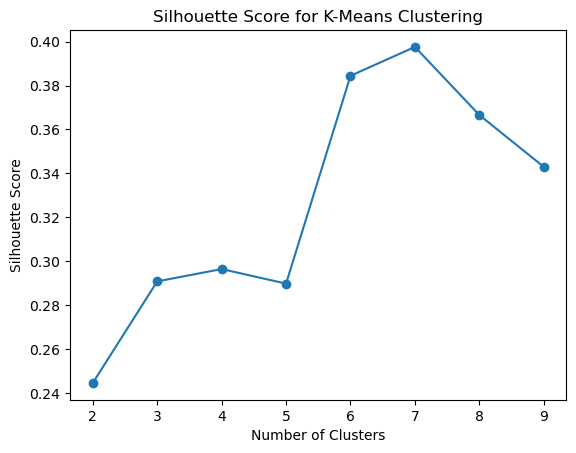

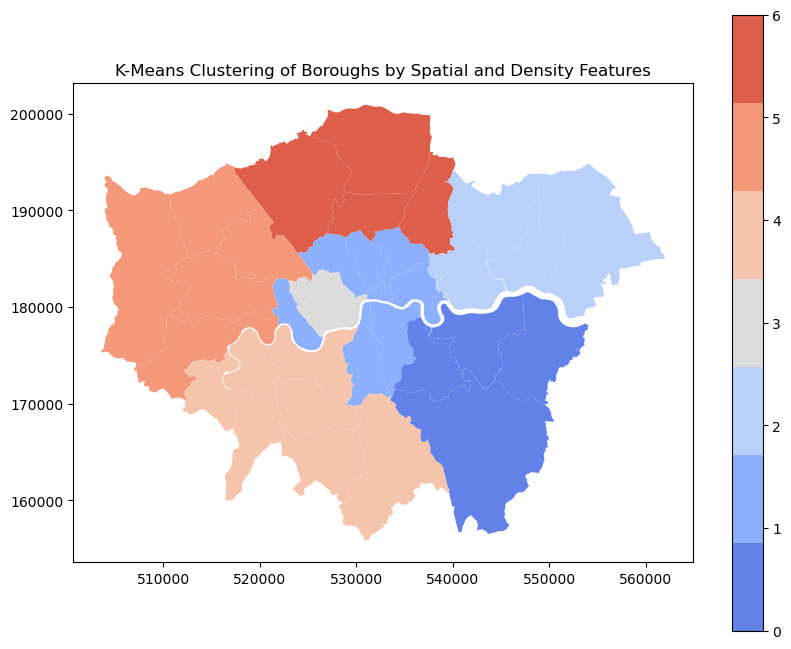

In [113]:
import geopandas as gpd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap

# Extract the geometric center and density values of the area.
bor["centroid"] = bor.geometry.centroid  
bor["x"] = bor["centroid"].x  
bor["y"] = bor["centroid"].y 
cluster_data = bor[["x", "y", "Density"]].values

# Data normalization
scaler = StandardScaler()
cluster_data_scaled = scaler.fit_transform(cluster_data)

# get the suitable number of clusterings by ilhouette_score
from sklearn.metrics import silhouette_score

silhouette_scores = []
for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(cluster_data_scaled)
    score = silhouette_score(cluster_data_scaled, labels)
    silhouette_scores.append(score)

plt.plot(range(2, 10), silhouette_scores, marker='o')
plt.title("Silhouette Score for K-Means Clustering")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.show()


# Make clusterings of 7
n_clusters = 7  
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
bor["Cluster1"] = kmeans.fit_predict(cluster_data_scaled)  

# Visualization using seaborn color palette
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

# Choose a seaborn color palette and convert it to a ListedColormap
palette = sns.color_palette("coolwarm", n_colors=n_clusters)  # generate color palette
cmap = ListedColormap(palette.as_hex())  # Convert palette to ListedColormap

# Plot using the chosen color palette
bor.plot(column="Cluster1", cmap=cmap, legend=True, ax=ax)

plt.title("K-Means Clustering of Boroughs by Spatial and Density Features")
plt.savefig("kmeans_clustering_boroughdensity_seaborn.png", dpi=300, bbox_inches="tight")
plt.show()


In [114]:
print(bor)
# Extract the required columns.
density_cluster = bor[["GSS_CODE","NAME", "Cluster1","Point_Count","Density","Area_km2"]]

# save as files
density_cluster.to_csv("Boroughdensity.csv", index=False, encoding="utf-8")


                      NAME   GSS_CODE   HECTARES  NONLD_AREA ONS_INNER  \
0     Kingston upon Thames  E09000021   3726.117       0.000         F   
1                  Croydon  E09000008   8649.441       0.000         F   
2                  Bromley  E09000006  15013.487       0.000         F   
3                 Hounslow  E09000018   5658.541      60.755         F   
4                   Ealing  E09000009   5554.428       0.000         F   
5                 Havering  E09000016  11445.735     210.763         F   
6               Hillingdon  E09000017  11570.063       0.000         F   
7                   Harrow  E09000015   5046.330       0.000         F   
8                    Brent  E09000005   4323.270       0.000         F   
9                   Barnet  E09000003   8674.837       0.000         F   
10                 Lambeth  E09000022   2724.940      43.927         T   
11               Southwark  E09000028   2991.340     105.139         T   
12                Lewisham  E09000023 

In [115]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
from libpysal.weights import Queen  #
from esda.moran import Moran, Moran_Local
from splot.esda import moran_scatterplot, lisa_cluster

# Create Queen contiguity weight matrix.
w = Queen.from_dataframe(bor)  
# Weight matrix normalization.
w.transform = "r"

# Calculate global Moran's I.
moran = Moran(bor["Density"], w)
print(f"Moran's I: {moran.I}")
print(f"p-value: {moran.p_sim}")


Moran's I: 0.4631876352055058
p-value: 0.001


/tmp/ipykernel_91420/1514143221.py:9: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w = Queen.from_dataframe(bor)


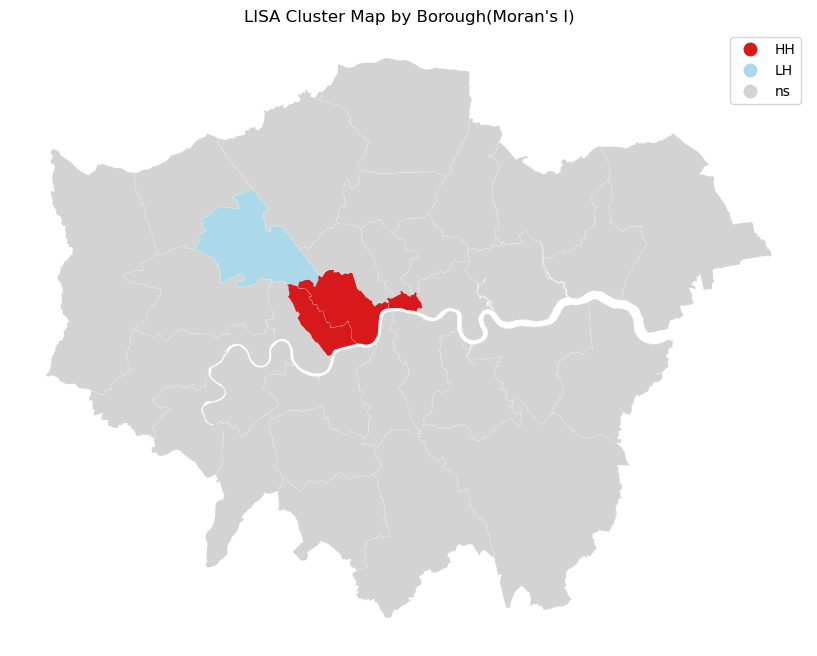

                      NAME   GSS_CODE   HECTARES  NONLD_AREA ONS_INNER  \
0     Kingston upon Thames  E09000021   3726.117       0.000         F   
1                  Croydon  E09000008   8649.441       0.000         F   
2                  Bromley  E09000006  15013.487       0.000         F   
3                 Hounslow  E09000018   5658.541      60.755         F   
4                   Ealing  E09000009   5554.428       0.000         F   
5                 Havering  E09000016  11445.735     210.763         F   
6               Hillingdon  E09000017  11570.063       0.000         F   
7                   Harrow  E09000015   5046.330       0.000         F   
8                    Brent  E09000005   4323.270       0.000         F   
9                   Barnet  E09000003   8674.837       0.000         F   
10                 Lambeth  E09000022   2724.940      43.927         T   
11               Southwark  E09000028   2991.340     105.139         T   
12                Lewisham  E09000023 

In [116]:
from esda.moran import Moran_Local
from splot.esda import lisa_cluster
import libpysal
import geopandas as gpd

# Calculate local Moran's I.
lisa = Moran_Local(bor["Density"], w)

# Add cluster types and significance.
bor["lisa_cluster"] = lisa.q  
bor["lisa_sig"] = lisa.p_sim  

# Cluster type description：
# 1 = High-High ：Boroughs with high values surrounded by neighboring boroughs with high values(clusters of high values).
# 2 = Low-Low ：Boroughs with low values surrounded by neighboring boroughs with low values (clusters of low values).
# 3 = High-Low ：Boroughs with high values surrounded by neighboring boroughs with low values (high-value outliers).
# 4 = Low-High： Boroughs with low values surrounded by neighboring boroughs with high values (low-value outliers).
from splot.esda import lisa_cluster

# plot the Lisa result
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
lisa_cluster(lisa, bor, p=0.05, ax=ax)
plt.title("LISA Cluster Map by Borough(Moran's I)")
plt.savefig("12_Moran'I_boroughdensity.png", dpi=300, bbox_inches="tight")
plt.show()
print(bor)


In [117]:
# Extract the required columns.
Moran_I = bor[["GSS_CODE","NAME", "lisa_cluster","lisa_sig"]]

# save as csv
Moran_I.to_csv("boroughdensity_Moran_I.csv", index=False, encoding="utf-8")


In [118]:
import pandas as pd

# read listings
listings = pd.read_csv("data/listings.csv", encoding="ISO-8859-1")

# Keep the required columns.
columns_to_keep = ['calculated_host_listings_count','id', 'latitude', 'longitude', 'price', 'host_id']
listings = listings[columns_to_keep]

# Remove missing values.
listings = listings.dropna()

# Display the processed data.
print(listings.head())

# save as a file
listings.to_csv("processed_listings.csv", index=False)


   calculated_host_listings_count      id   latitude  longitude  price  \
0                               1  116268  51.611370  -0.118880   40.0   
1                               1  117203  51.501550  -0.233002  131.0   
2                               1  127652  51.559528  -0.144319  215.0   
4                               2  131444  51.491476  -0.111514  150.0   
5                               1  137581  51.510990  -0.078620  145.0   

   host_id  
0   586671  
1   255103  
2   134938  
4   646165  
5   471088  


In [119]:
#  creat the points
geometry = [Point(xy) for xy in zip(listings["longitude"], df["latitude"])]

#  Creat a GeoDataFrame，define the original CRS as WGS84
gdf2 = gpd.GeoDataFrame(listings, geometry=geometry, crs="EPSG:4326")

# projection to the British CRS
gdf2_projected = gdf2.to_crs("EPSG:27700")

import geopandas as gpd
import pandas as pd
from shapely.geometry import Point
import matplotlib.pyplot as plt
points_gdf2 = gdf2.to_crs(bor.crs)
# Spatial Join: Linking point data with area data.
points_with_regions2 = gpd.sjoin(points_gdf2, bor, how="left", predicate="within")

# Add the column as names of boroughs
points_with_regions2 = points_with_regions2.rename(columns={"GSS_CODE": "GSS_CODE"})

# show the result
print(points_with_regions2)
print(points_with_regions2[["calculated_host_listings_count", "longitude", "latitude", "GSS_CODE"]])


       calculated_host_listings_count                   id   latitude  \
0                                   1               116268  51.611370   
1                                   1               117203  51.501550   
2                                   1               127652  51.559528   
4                                   2               131444  51.491476   
5                                   1               137581  51.510990   
...                               ...                  ...        ...   
96177                               1  1239087592369786950  51.547717   
96178                              37  1239112017665871678  51.505380   
96179                              37  1239112357239275295  51.505380   
96180                              37  1239116439240556456  51.505380   
96181                              33  1239118358582762076  51.539411   

       longitude  price    host_id                       geometry  \
0      -0.118880   40.0     586671  POINT (530348.644 

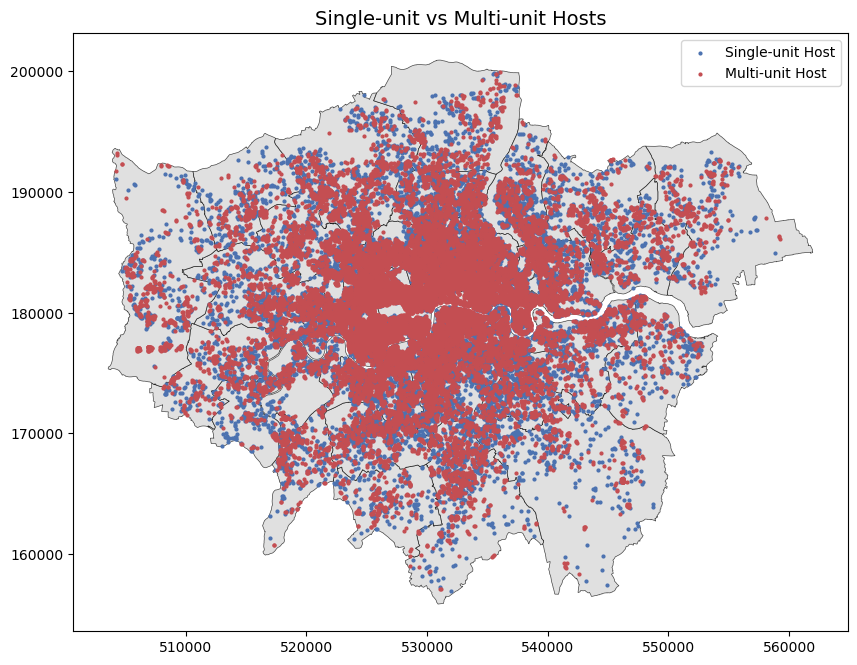

In [120]:
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns  # 导入Seaborn库
# make sure the same CRS
if gdf2.crs != bor.crs:
    gdf2 = gdf2.to_crs(bor.crs)
# use Seaborn color
sns_colors = sns.color_palette("deep") 
blue = sns_colors[0]  
red = sns_colors[3]   

# 绘图
fig, ax = plt.subplots(figsize=(10, 10))

# background is bor
bor.plot(ax=ax, color="lightgrey", edgecolor="black", linewidth=0.5, alpha=0.7)

# make the point plot
gdf2[gdf2['calculated_host_listings_count'] == 1].plot(
    ax=ax, color=blue, label="Single-unit Host", markersize=4
)
gdf2[gdf2['calculated_host_listings_count'] > 1].plot(
    ax=ax, color=red, label="Multi-unit Host", markersize=4
)

# Add a title and legend.
ax.set_title("Single-unit vs Multi-unit Hosts", fontsize=14)
ax.legend()

# show the result
plt.savefig("Single-unit vs Multi-unit Hosts.png", dpi=300, bbox_inches="tight")
plt.show()


In [121]:
# Group by GSS_CODE and calculate the count of id and the number of unique host_id for each area.
result = points_with_regions2.groupby("GSS_CODE").agg(
    id_count=("id", "count"),                
    host_id_count=("host_id", "nunique")     
).reset_index()

# Calculate the average number of listings per host.
result["id_host_ratio"] = result["id_count"] / result["host_id_count"]
points_with_regions2 = points_with_regions2.merge(
    result[["GSS_CODE", "id_count", "host_id_count", "id_host_ratio"]],
    on="GSS_CODE",
    how="left"
)
# show the result
print(points_with_regions2.head())


print(points_with_regions2)


   calculated_host_listings_count      id   latitude  longitude  price  \
0                               1  116268  51.611370  -0.118880   40.0   
1                               1  117203  51.501550  -0.233002  131.0   
2                               1  127652  51.559528  -0.144319  215.0   
3                               2  131444  51.491476  -0.111514  150.0   
4                               1  137581  51.510990  -0.078620  145.0   

   host_id                       geometry  index_right  \
0   586671  POINT (530348.644 191957.524)           15   
1   255103  POINT (522742.258 179547.882)           22   
2   134938  POINT (528733.585 186147.463)           25   
3   646165   POINT (531202.89 178638.176)           10   
4   471088  POINT (533429.313 180867.557)           32   

                     NAME   GSS_CODE  ...     Density  \
0                 Enfield  E09000010  ...    7.554727   
1  Hammersmith and Fulham  E09000013  ...  162.157703   
2                  Camden  E0900000

In [122]:
import pandas as pd
import geopandas as gpd

# read final_neighbourhood_prices.csv 
neighbourhood_prices = pd.read_csv("data/final_neighbourhood_prices.csv")

print(neighbourhood_prices.head())
print(points_with_regions2.head())

# join 'weighted_price'to points_with_regions2 
points_with_prices = points_with_regions2.merge(
    neighbourhood_prices[['neighbourhood', 'weighted_price']],  
    left_on='NAME',    
    right_on='neighbourhood',  
    how='left'        
)

# show the result
print(points_with_prices.head())



          neighbourhood  weighted_price
0  Barking and Dagenham      111.605042
1                Barnet      138.207671
2                Bexley       99.355319
3                 Brent      155.698219
4               Bromley      113.805839
   calculated_host_listings_count      id   latitude  longitude  price  \
0                               1  116268  51.611370  -0.118880   40.0   
1                               1  117203  51.501550  -0.233002  131.0   
2                               1  127652  51.559528  -0.144319  215.0   
3                               2  131444  51.491476  -0.111514  150.0   
4                               1  137581  51.510990  -0.078620  145.0   

   host_id                       geometry  index_right  \
0   586671  POINT (530348.644 191957.524)           15   
1   255103  POINT (522742.258 179547.882)           22   
2   134938  POINT (528733.585 186147.463)           25   
3   646165   POINT (531202.89 178638.176)           10   
4   471088  POINT (533429

In [123]:
import pandas as pd
import geopandas as gpd
points_data = points_with_prices[['NAME', 'weighted_price', 'id_host_ratio']]
# join with bor and new data
bor = bor.merge(
    points_data.groupby('NAME', as_index=False).mean(), 
    on='NAME',      
    how='left'      
)
# show the result
print(bor.head())


                   NAME   GSS_CODE   HECTARES  NONLD_AREA ONS_INNER SUB_2009  \
0  Kingston upon Thames  E09000021   3726.117       0.000         F     None   
1               Croydon  E09000008   8649.441       0.000         F     None   
2               Bromley  E09000006  15013.487       0.000         F     None   
3              Hounslow  E09000018   5658.541      60.755         F     None   
4                Ealing  E09000009   5554.428       0.000         F     None   

  SUB_2006                                           geometry       Area_m2  \
0     None  POLYGON ((516401.6 160201.8, 516407.3 160210.5...  3.726118e+07   
1     None  POLYGON ((535009.2 159504.7, 535005.5 159502, ...  8.649444e+07   
2     None  POLYGON ((540373.6 157530.4, 540361.2 157551.9...  1.501349e+08   
3     None  POLYGON ((521975.8 178100, 521967.7 178096.8, ...  5.592623e+07   
4     None  POLYGON ((510253.5 182881.6, 510249.9 182886, ...  5.554435e+07   

     Area_km2  Point_Count    Density       

In [124]:
import pandas as pd
from scipy.stats import pearsonr

# Extract the weighted_price and id_host_ratio columns and remove missing values.
data = bor[['weighted_price', 'id_host_ratio']].dropna()

#  Calculate the Pearson correlation coefficient and p-value.
pearson_coef, p_value = pearsonr(data['weighted_price'], data['id_host_ratio'])
print("\nPearson Correlation Coefficient:", pearson_coef)
print("P-value:", p_value)



Pearson Correlation Coefficient: 0.7302925713517088
P-value: 1.4062998636490447e-06
